In [1]:
import requests
import pandas as pd
import time
from cryptocmd import CmcScraper
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
# list of cryptocurrencies to scrape
crypto_list = ['BTC', 'ETH', 'USDT', 'USDC', 'BNB', 'ADA', 'XRP', 'SOL', 'DOGE', 'DOT', 'DAI', 'TRX', 'SHIB', 'AVAX', 'LTC', 'FTT', 'XLM', 'LINK', 'MATIC', 'BCH', 'UNI', 'ALGO', 'VET', 'HBAR', 'SAND', 'MANA', 'AXS', 'XTZ', 'EOS', 'AAVE', 'HT', 'GRT', 'FTM', 'PAXG', 'ZIL', 'BAT', 'CHZ', 'ENJ', 'LRC', 'GALA', 'COMP']

# empty list to store scraped data
data = []

# loop over cryptocurrencies
for crypto in crypto_list:
    # scrape data for each cryptocurrency
    scraper = CmcScraper(crypto, "15-09-2022", "01-03-2023")
    df = scraper.get_dataframe()
    
    # add cryptocurrency name to dataframe
    df['Name'] = crypto
    
    # append dataframe to list of data
    data.append(df)

# combine dataframes for each cryptocurrency
df_combined = pd.concat(data)

df_combined = df_combined.loc[:, ['Date', 'Close', 'Market Cap', 'Name']]

In [3]:
# Read the ESG scores dataframe from the CSV file
esg_scores = pd.read_csv('CRYPTOESGCHANGE.csv')

# Merge the two dataframes on the 'Name' column
merged_data = pd.merge(df_combined, esg_scores, on='Name')

In [4]:
print(merged_data)

           Date         Close    Market Cap  Name ESG   E  S  G
0    2023-03-01  23646.549899  4.565082e+11   BTC    C  E  A  A
1    2023-02-28  23147.353390  4.468468e+11   BTC    C  E  A  A
2    2023-02-27  23522.871915  4.540752e+11   BTC    C  E  A  A
3    2023-02-26  23561.212911  4.547952e+11   BTC    C  E  A  A
4    2023-02-25  23175.375636  4.473240e+11   BTC    C  E  A  A
...         ...           ...           ...   ...  ... .. .. ..
6883 2022-09-19     52.125630  3.788049e+08  COMP    A  A  C  A
6884 2022-09-18     49.423509  3.591682e+08  COMP    A  A  C  A
6885 2022-09-17     54.493153  3.960100e+08  COMP    A  A  C  A
6886 2022-09-16     54.003687  3.924530e+08  COMP    A  A  C  A
6887 2022-09-15     56.501139  4.106024e+08  COMP    A  A  C  A

[6888 rows x 8 columns]


# Creation of ESG portfolios

## Equally weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio        Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  ----------
 0  A                      0.0676599             0.0194828        0.474042         0.757882            0.0468543   0.0044345
 1  C                      0.131853              0.0263761        0.6584           1.02867             0.054159   -0.0272213


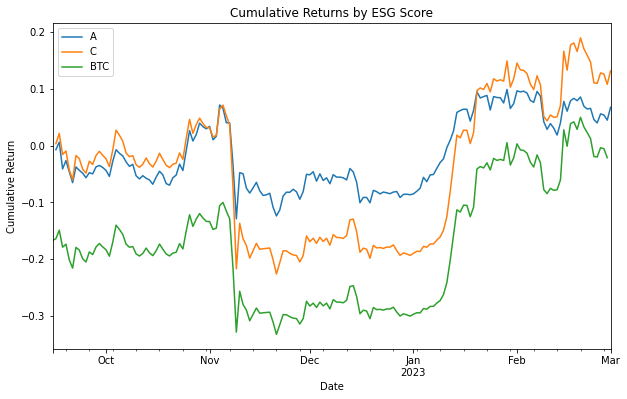

In [5]:
esg_scores = ['A','C']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')['Close']

for score in esg_scores:
    esg_df = merged_data[merged_data['ESG ']==score]
    portfolio_df = esg_df.groupby('Date').sum()['Close']

    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df / btc_df.shift(1))

    portfolio_cum_return = (portfolio_returns + 1).cumprod() - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = excess_returns.mean() / excess_returns.std()
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by ESG Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()


# Create table of portfolio metrics for all scores
results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)

# Format table with tabulate
table_str = tabulate(results_table, headers='keys', tablefmt='simple')

# Print formatted table
print(table_str)


## Capitalization weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio         Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  -----------
 0  A                       0.21162              0.0476994        0.382541         0.582052            0.0360903   0.00921118
 1  C                       0.214097             0.0253185        0.728366         1.16109             0.0569066  -0.0342462


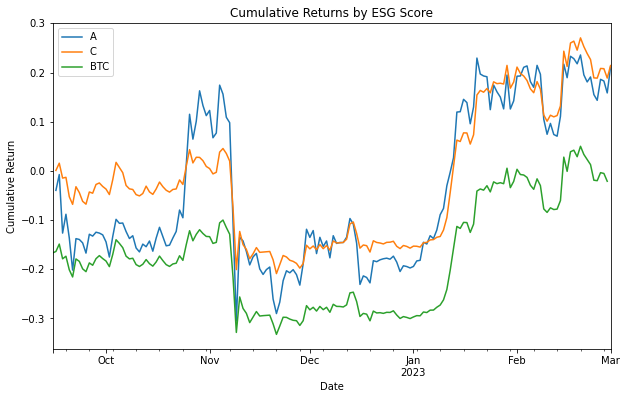

In [6]:
esg_scores = ['A', 'C']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')
btc_market_cap = btc_df.iloc[0]['Market Cap']
btc_weights = btc_df['Market Cap'] / btc_market_cap

for score in esg_scores:
    esg_df = merged_data[merged_data['ESG ']==score]
    portfolio_df = esg_df.groupby('Date').apply(lambda x: np.sum(x['Close']*x['Market Cap']) / np.sum(x['Market Cap']))
    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df['Close'] / btc_df['Close'].shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = excess_returns.mean() / excess_returns.std()
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by ESG Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)
table_str = tabulate(results_table, headers='keys', tablefmt='simple')
print(table_str)


# Creation of E portfolios

## Equally weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio         Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  -----------
 0  A                      0.0979831             0.0197376        0.450179         0.716486            0.0459634   0.00464342
 1  E                      0.201412              0.026338         0.662264         1.03533             0.054323   -0.027346


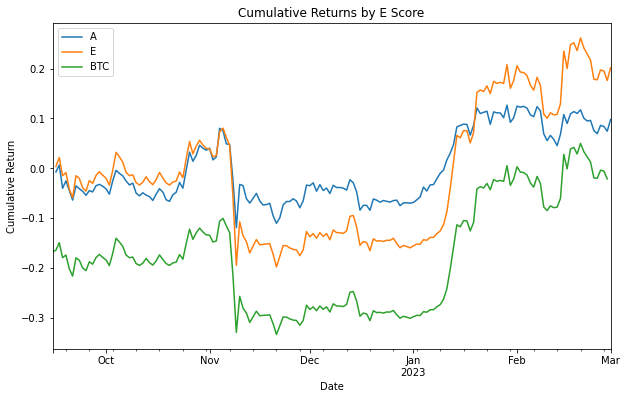

In [7]:
e_scores = ['A', 'E']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')['Close']

for score in e_scores:
    esg_df = merged_data[merged_data['E']==score]
    portfolio_df = esg_df.groupby('Date').sum()['Close']

    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df / btc_df.shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = excess_returns.mean() / excess_returns.std()
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by E Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()


# Create table of portfolio metrics for all scores
results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)

# Format table with tabulate
table_str = tabulate(results_table, headers='keys', tablefmt='simple')

# Print formatted table
print(table_str)

## Capitalization weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio         Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  -----------
 0  A                       0.213733             0.0466904        0.394354         0.602434            0.0368405   0.00484901
 1  E                       0.191438             0.0260042        0.640289         1.00761             0.0534246  -0.0245631


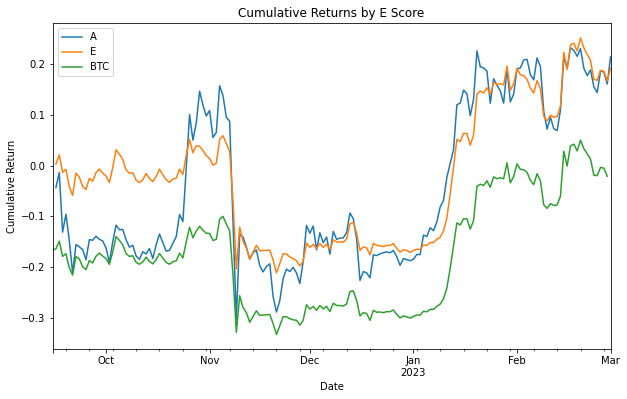

In [8]:
e_scores = ['A', 'E']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')
btc_market_cap = btc_df.iloc[0]['Market Cap']
btc_weights = btc_df['Market Cap'] / btc_market_cap

for score in e_scores:
    esg_df = merged_data[merged_data['E']==score]
    portfolio_df = esg_df.groupby('Date').apply(lambda x: np.sum(x['Close']*x['Market Cap']) / np.sum(x['Market Cap']))
    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df['Close'] / btc_df['Close'].shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = excess_returns.mean() / excess_returns.std()
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by E Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)
table_str = tabulate(results_table, headers='keys', tablefmt='simple')
print(table_str)

# Creation of S portfolios

## Equally weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio        Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  ----------
 0  A                      0.192357              0.0243933        0.685582         1.07967             0.0553443  -0.0228159
 1  C                     -0.051337              0.0456658       -0.109703        -0.172685            0.0082301   0.0714401
 2  D                      0.0984995             0.0372662        0.239631         0.358179            0.0312496  -0.0108128


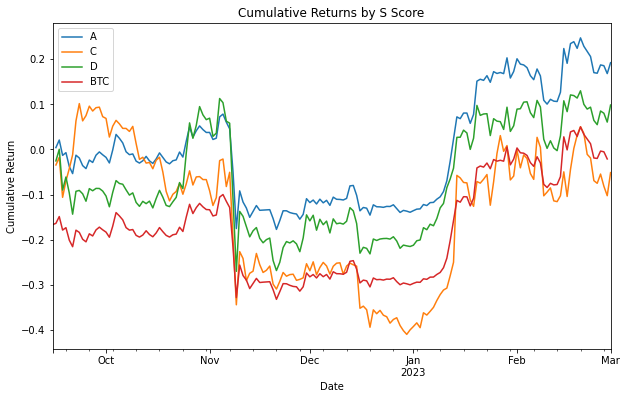

In [9]:
s_scores = ['A', 'C', 'D']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')['Close']

for score in s_scores:
    esg_df = merged_data[merged_data['S']==score]
    portfolio_df = esg_df.groupby('Date').sum()['Close']

    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df / btc_df.shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = excess_returns.mean() / excess_returns.std()
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by S Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()


# Create table of portfolio metrics for all scores
results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)

# Format table with tabulate
table_str = tabulate(results_table, headers='keys', tablefmt='simple')

# Print formatted table
print(table_str)

## Capitalization weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio          Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  ------------
 0  A                      0.274382              0.0314345       0.733194          1.14951             0.0569221  -0.0499214
 1  C                     -0.0384766             0.0399781      -0.0932932        -0.142661            0.0111545   0.0731152
 2  D                      0.161002              0.0372446       0.381006          0.588856            0.0382607  -0.000441825


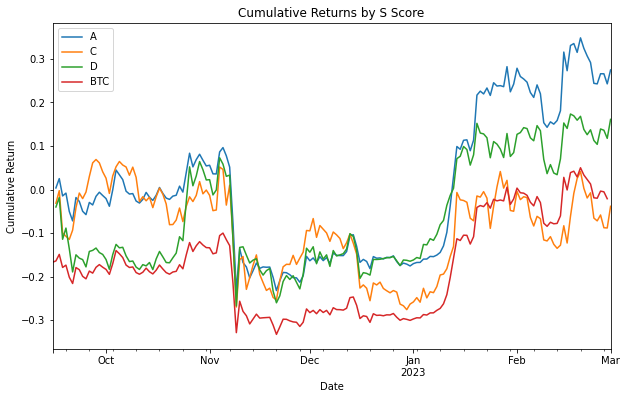

In [10]:
s_scores = ['A', 'C', 'D']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')
btc_market_cap = btc_df.iloc[0]['Market Cap']
btc_weights = btc_df['Market Cap'] / btc_market_cap

for score in s_scores:
    esg_df = merged_data[merged_data['S']==score]
    portfolio_df = esg_df.groupby('Date').apply(lambda x: np.sum(x['Close']*x['Market Cap']) / np.sum(x['Market Cap']))
    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df['Close'] / btc_df['Close'].shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = excess_returns.mean() / excess_returns.std()
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by S Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)
table_str = tabulate(results_table, headers='keys', tablefmt='simple')
print(table_str)

# Creation of G portfolios
## Equally weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio        Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  ----------
 0  A                     0.193051               0.024347        0.689153         1.08769              0.0553803  -0.0258976
 1  C                     0.124259               0.0368213       0.302365         0.455708             0.034495    0.001839
 2  D                    -0.00827889             0.0347781      -0.0227224       -0.0329454            0.0233277   0.118172


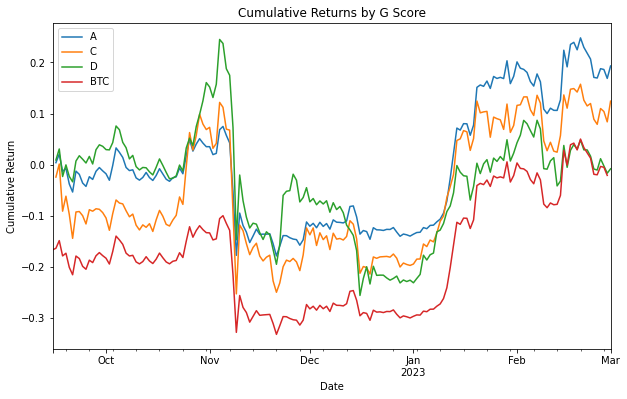

In [11]:
g_scores = ['A', 'C', 'D']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')['Close']

for score in g_scores:
    esg_df = merged_data[merged_data['G']==score]
    portfolio_df = esg_df.groupby('Date').sum()['Close']

    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df / btc_df.shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = excess_returns.mean() / excess_returns.std()
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by G Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()


# Create table of portfolio metrics for all scores
results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)

# Format table with tabulate
table_str = tabulate(results_table, headers='keys', tablefmt='simple')

# Print formatted table
print(table_str)

# Capitalization weighted portfolios

    Portfolio      Cumulative Return    Standard Deviation    Sharpe Ratio    Sortino Ratio    Information Ratio         Beta
--  -----------  -------------------  --------------------  --------------  ---------------  -------------------  -----------
 0  A                       0.272828             0.0318796        0.71932          1.12319             0.0567677  -0.0302284
 1  C                       0.133953             0.0366023        0.326472         0.496612            0.0361214   0.00100716
 2  D                       0.122462             0.0352614        0.31143          0.484219            0.0459572   0.269667


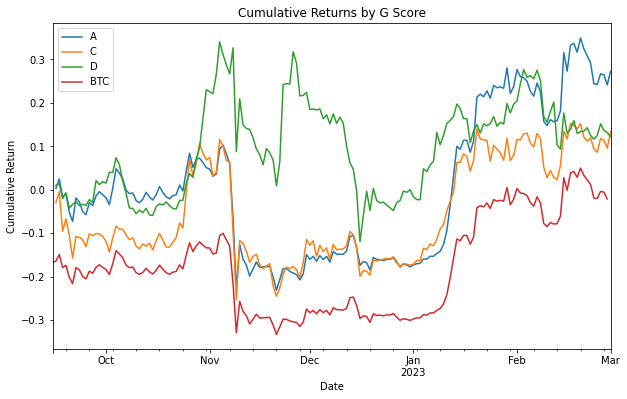

In [12]:
g_scores = ['A', 'C', 'D']
metrics = ['Cumulative Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Information Ratio', 'Beta']
metric_funcs = [lambda x: (x[-1]/x[0])-1, np.std, lambda x: np.mean(x) / np.std(x), lambda x: np.mean(np.minimum(x, 0)) / np.std(np.minimum(x, 0)), None, None]

results = []
cum_returns = pd.DataFrame()

btc_df = merged_data[merged_data['Name'] == 'BTC'].set_index('Date')
btc_market_cap = btc_df.iloc[0]['Market Cap']
btc_weights = btc_df['Market Cap'] / btc_market_cap

for score in g_scores:
    esg_df = merged_data[merged_data['G']==score]
    portfolio_df = esg_df.groupby('Date').apply(lambda x: np.sum(x['Close']*x['Market Cap']) / np.sum(x['Market Cap']))
    portfolio_returns = np.log(portfolio_df / portfolio_df.shift(1))
    btc_returns = np.log(btc_df['Close'] / btc_df['Close'].shift(1))

    portfolio_cum_return = np.exp(portfolio_returns.cumsum()) - 1
    cum_returns[score] = portfolio_cum_return

    portfolio_std_dev = portfolio_returns.std()
    portfolio_sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
    portfolio_sortino_ratio = (portfolio_returns.mean() / np.std(np.minimum(portfolio_returns, 0))) * np.sqrt(252)

    excess_returns = portfolio_returns - btc_returns
    information_ratio = excess_returns.mean() / excess_returns.std()
    covariance = portfolio_returns.cov(btc_returns)
    beta = covariance / btc_returns.var()

    results.append([score, portfolio_cum_return.iloc[-1], portfolio_std_dev, portfolio_sharpe_ratio, portfolio_sortino_ratio, information_ratio, beta])

cumulative_btc_returns = np.exp(btc_returns.cumsum()) - 1
cum_returns['BTC'] = cumulative_btc_returns

cum_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns by G Score')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

results_table = pd.DataFrame(results, columns=['Portfolio'] + metrics)
table_str = tabulate(results_table, headers='keys', tablefmt='simple')
print(table_str)